In [78]:
import os, io
from google.cloud import vision_v1 as vision
from google.cloud.vision_v1 import types
import pandas as pd
import cv2
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import imagehash
# from IPython.display import Image
from enum import Enum
from termcolor import colored
%matplotlib inline

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'Demz_vision_API_token.json'

In [79]:
# Path to the two License
Driver_License = 'test11.jpg'
PCO_License = 'test1.jpg'
FOLDER_PATH = 'C:\\Users\\USER\\Desktop\\NEW_DEMZ\\OCR\\OCR_Works\\Google\\images'

In [80]:
client = vision.ImageAnnotatorClient()
crop_hints_params = vision.CropHintsParams(aspect_ratios=[1.77])

# Get License Response from GOOGLE API

In [81]:
# Drivers License response
with io.open(os.path.join(FOLDER_PATH, Driver_License), 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
Drivers_response = client.text_detection(image=content_image)
Drivers_response_face = client.face_detection(image=content_image)
Drivers_texts = Drivers_response.text_annotations
Drivers_faceAnnotations = Drivers_response_face.face_annotations

In [82]:
# PCO License response
with io.open(os.path.join(FOLDER_PATH, PCO_License), 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
PCO_response = client.text_detection(image=content_image)
PCO_response_face = client.face_detection(image=content_image)
PCO_texts = PCO_response.text_annotations
PCO_faceAnnotations = PCO_response_face.face_annotations

# Crop Both License Images

In [83]:
def get_crop_hint(crop_hints):
    """Detect crop hints on a single image and return the first result."""
    with io.open(crop_hints, 'rb') as image_file1:
        content = image_file1.read()
        
    image = vision.Image(content=content)
    
    image_context = vision.ImageContext(crop_hints_params=crop_hints_params)

    response = client.crop_hints(image=image, image_context=image_context)
    hints = response.crop_hints_annotation.crop_hints

    # Get bounds for the first crop hint using an aspect ratio of 1.77.
    vertices = hints[0].bounding_poly.vertices

    return vertices

In [84]:
def crop_Driver_hint(image_file):
    """Crop the image using the hints in the vector list."""
    vects = get_crop_hint(image_file)
#     response_face = Drivers_response_face
    faceAnnotations = Drivers_faceAnnotations
    try:
        face_bounds = []
        for face in faceAnnotations:
            face_vertices = (['({0},{1})'.format(vertex.x, vertex.y) for vertex in face.bounding_poly.vertices])
            face_bounds.append(face_vertices)
        bound_1 = face_bounds[0][0]
        bound_2 = face_bounds[0][2]
        bound_1 = eval(bound_1)
        bound_2 = eval(bound_2)

        im = Image.open(image_file)

        im2 = im.crop([bound_1[0], bound_1[1],
                      bound_2[0] - 1, bound_2[1] - 1])
    #     plt.imshow(im2)
    #     im2.save('output-crop.jpg', 'JPEG')
        print('Saved new image to output-crop.jpg')
        return im2
    except:
        print("No Image Detected")
    

In [85]:
def crop_PCO_hint(image_file):
    """Crop the image using the hints in the vector list."""
    vects = get_crop_hint(image_file)
#     response_face = PCO_response_face
    faceAnnotations = PCO_faceAnnotations
    try:
        face_bounds = []
        for face in faceAnnotations:
            face_vertices = (['({0},{1})'.format(vertex.x, vertex.y) for vertex in face.bounding_poly.vertices])
            face_bounds.append(face_vertices)
        bound_1 = face_bounds[0][0]
        bound_2 = face_bounds[0][2]
        bound_1 = eval(bound_1)
        bound_2 = eval(bound_2)

        im = Image.open(image_file)

        im2 = im.crop([bound_1[0], bound_1[1],
                      bound_2[0] - 1, bound_2[1] - 1])
    #     plt.imshow(im2)
    #     im2.save('output-crop.jpg', 'JPEG')
        print('Saved new image to output-crop.jpg')
        return im2
    except:
        print("No Image Detected")
    

In [86]:
Driver_Image = crop_Driver_hint(os.path.join(FOLDER_PATH, Driver_License))
PCO_IMage = crop_PCO_hint(os.path.join(FOLDER_PATH, PCO_License))

Saved new image to output-crop.jpg
Saved new image to output-crop.jpg


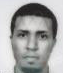

In [87]:
Driver_Image

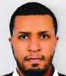

In [88]:
PCO_IMage

# Processing License Text

In [140]:
def Processor(Drivers_texts, PCO_texts):
    Drivers_contents = []
    PCO_contents = []
    
    # Extract Driver License Contents
    for text in Drivers_texts:
        Drivers_contents.append(text.description)
    
    # Extract PCO License Contents
    for text in PCO_texts:
        PCO_contents.append(text.description)
        
    Driver_String_Content = Drivers_contents[0]
    PCO_String_Content = PCO_contents[0]
    
#     print(PCO_contents)

    # Process the PCO License
    def Process_PCO_License(PCO_String_Content):
        if 'Expire Date' in PCO_String_Content:
            new_pco_list = PCO_String_Content.split('Expire Date:')
        elif 'Expiry Date:' in PCO_String_Content:
            new_pco_list = PCO_String_Content.split('Expiry Date:')
        else:
            new_pco_list = PCO_String_Content.split('Expiry Date')
        new_pco = new_pco_list[-1]
        Expiry_date = new_pco_list[-1].split('\n')
        Expiry_date = [date for date in Expiry_date if date != ''][0]
        new_pco_content = new_pco_list[0]

        def get_pco_license_NO(new_pco_content):
            license_NO = re.findall(r'\d',new_pco_content)
            license_NO = ''.join(license_NO)
            return license_NO
        PCO_license_NO = get_pco_license_NO(new_pco_content)
#         print(PCO_license_NO)
        new_pco_content = new_pco_content.split(PCO_license_NO)

        new_pco_content = new_pco_content[-1]
        new_pco_content = new_pco_content.split('\n')

        new_pco_content = [name for name in new_pco_content if name != '']
        First_Name = new_pco_content[0]
        Other_Name = new_pco_content[-1]
        Full_Name = First_Name + ' '+ Other_Name
        Full_Name = Full_Name.split(' ')
        Full_Name = sorted(Full_Name)
        Full_Name = ' '.join(Full_Name)
        print(Full_Name)

        PCO_CONTENT = {}

        PCO_CONTENT['Full_Name'] = Full_Name
#         PCO_CONTENT['Other Name'] = new_pco_content[-1]
        PCO_CONTENT['License Number'] = PCO_license_NO
        PCO_CONTENT['Expiry Date'] = Expiry_date
        
        return PCO_CONTENT
    
#     print(Process_PCO_License(PCO_String_Content))
    def Process_Driver_License(Driver_String_Content):
#         print(Driver_String_Content)
        
        if 'DRIVING LICENCE' in Driver_String_Content:
            if 'DRIVING LICENCE' in Driver_String_Content:
                Driver_contents = Driver_String_Content.split('DRIVING LICENCE')[-1]
            elif '1.' in Driver_String_Content:
                Driver_contents = re.split('1.', Driver_String_Content, 1)[-1]
            else:
                Driver_contents = Driver_String_Content
                print('No Split Found')
    #       Dates
            dates = re.findall(r"([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)(19[0-9][0-9]|20[0-9][0-9]|[0-9][0-9])", Driver_contents)
            new_dates = []
            for date in dates:
                dat = ''.join(date)
                new_dates.append(dat)
            if len(new_dates) >= 3:
                date_and_POB = re.search(f'{new_dates[0]}.*\n', Driver_contents).group(0).split('\n')[0]
                issued_date = new_dates[1]
                Renew_due_date = new_dates[2]
            else:
                dates = re.findall("\d\d.*\d\d",Driver_contents)
                date_and_POB = re.search(f'{dates[0]}.*\n', Driver_contents).group(0).split('\n')[0]
                issued_date = dates[1]
                Renew_due_date = dates[2]

    #       Names
            Names = Driver_contents.split(date_and_POB)[0]
            Names = re.split('\d.',Names)
            Names = ' '.join(Names)
            Names = Names.split('\n')
            Names = [name.strip() for name in Names if name]
            Names = [name for name in Names if name]
            if Names[0] == 'UK':
                Names = Names[1:]
            if len(Names) > 2:
                First_Name = Names[0]
                if not 'UK' in Names:
                    Other_Name = ' '.join(Names[1:]) 
                else:
                    Other_Name = Names[1]
                Full_Name = First_Name + ' '+ Other_Name
                Full_Name = Full_Name.split(' ')
                Full_Name = sorted(Full_Name)
                Full_Name = ' '.join(Full_Name)
                print(Full_Name)
            else:
                First_Name = Names[0]
                Other_Name = Names[1]
                Full_Name = First_Name + ' '+ Other_Name
                Full_Name = Full_Name.split(' ')
                Full_Name = sorted(Full_Name)
                Full_Name = ' '.join(Full_Name)
                print(Full_Name)
                
    #       Authority
            Authority = re.search(f'{issued_date}.*\n', Driver_contents).group(0)
            Authority_EX = re.findall("\d\d.*\d\d", Authority)
            authority_date = []
            for date in Authority_EX:
                dat = ''.join(date)
                authority_date.append(dat)
            Authority = Authority.split(authority_date[-1])[-1]
            Authority = Authority.split(' ')[-1]
            Authority = Authority.split('\n')[0]

    #       LICENSE NUMBER
            License_No = Driver_contents.split(Renew_due_date)[1]
            License_No = License_No.split('\n')
            License_No = [license.strip() for license in License_No if license]
            match_license = []
            for license in License_No:
                if re.search("\w.*\d", license):
                    match_license.append(license)
            if len(match_license) > 0:
                License_No = match_license[0]
            else:
                License_No = 'None'

    #       Address
            Address = Driver_contents.split(License_No)[-1]
            Address_list = Address.split('\n')

            # Merge the Address if it continues in another line
            output = []
            for i in range(len(Address_list)-1):
                if str(Address_list[i]).endswith(','):
                    new_word = Address_list[i] +' '+ Address_list[i+1]
                    output.append(new_word)
                    next_word = Address_list[i+1]
                    Address_list.remove(next_word)
                elif Address_list[i] == max(Address_list, key=len) and str(Address_list[i]).endswith('.'):
                    new_word = Address_list[i] +' '+ Address_list[i+1]
                    output.append(new_word)
                    next_word = Address_list[i+1]
                    Address_list.remove(next_word)
                else:
                    new_word = Address_list[i]
                    output.append(new_word)

            Address_list = output  
            Address = max(Address_list, key=len)
            if Address.isupper():
                Address = Address
            elif max(Address_list, key=len):
                Address = Address
            else:
                Address = [address for address in Address_list if address.isupper()][0]

            # Entitlement categoory
            Entitlement_categoory = Driver_contents.split(License_No)[-1]
            Entitlement_categoory = Entitlement_categoory.split('\n')
            Entitlement_categoory = [category for category in Entitlement_categoory if category][-1]
            if Entitlement_categoory == max(Address_list, key=len):
                Entitlement_categoory = 'None'
            elif re.search(f"{Entitlement_categoory}", Address) :
                Entitlement_categoory = 'None'
            else:
                Entitlement_categoory = Entitlement_categoory.split(' ')[-1]
                Entitlement_categoory  = Entitlement_categoory


            DRIVER_CONTENT = {}

            DRIVER_CONTENT['Full_Name'] = Full_Name
#             DRIVER_CONTENT['Other Name'] = Other_Name
            DRIVER_CONTENT['Date and Place of birth'] = date_and_POB
            DRIVER_CONTENT['Issued Date'] = issued_date
            DRIVER_CONTENT['Renew Due Date'] = Renew_due_date
            DRIVER_CONTENT['Issuing authority'] = Authority
            DRIVER_CONTENT['License Number'] = License_No
            DRIVER_CONTENT['Address'] = Address
            DRIVER_CONTENT['Entitlement categories'] = Entitlement_categoory

            return DRIVER_CONTENT
        else:
            print('Document is Not a Driving License')
    
    PCO_CONTENT = Process_PCO_License(PCO_String_Content)
    DRIVER_CONTENT = Process_Driver_License(Driver_String_Content)
        
    return PCO_CONTENT, DRIVER_CONTENT 

In [141]:
PCO_CONTENT, DRIVER_CONTENT = Processor(Drivers_texts, PCO_texts)

Noor Sheikh Yasin
NOOR SHEIKH YASIN


In [142]:
# PCO_CONTENT
for x, y in PCO_CONTENT.items():
    print(x +":  " + colored(y, 'green'))
#     print(f"{x}\x1b[31m{':  ' + y}\x1b[0m")

Full_Name:  Noor Sheikh Yasin
License Number:  180567
Expiry Date:   16/12/2023


In [143]:
# DRIVER_CONTENT
for x, y in DRIVER_CONTENT.items():
    print(x +":  " + colored(y, 'blue'))
#     print(f"{x}\x1b[31m{':  ' + y}\x1b[0m")

Full_Name:  NOOR SHEIKH YASIN
Date and Place of birth:  03.05. 1984 SOMALIA
Issued Date:  21.08.2014
Renew Due Date:  20.06.2024
Issuing authority:  DVLA
License Number:  SHEIKBO5034Y9AD 16
Address:  a. 5a UPPER WALTHAMSTOW ROAD, WALTHAMSTOW. LONDON, E17 00
Entitlement categories:  AM/A/B1/B//k/p/q


# Compare both License Informations

In [144]:
def Compare_License(Driver_Content, PCO_Content, Driver_Image, PCO_IMage):
    
    def check_Match_Names(Driver_Content, PCO_Content):
        Driver_Full_Name = Driver_Content['Full_Name'].upper()       
        PCO_Full_Name = PCO_Content["Full_Name"].upper()
        
        Names_Match = {}
        if Driver_Full_Name == PCO_Full_Name:
            Names_Match["Full_Name_Matched"] = True
        else:
            Names_Match["Full_Name_Matched"] = False
            
        
        
        return Names_Match
    def check_Image_Similarities(Driver_Image, PCO_IMage):
        
        hash0 = imagehash.average_hash(Driver_Image)
        hash1 = imagehash.average_hash(PCO_IMage) 
        cutoff = 5

        Image_Similar = {}
        if hash0 - hash1 < cutoff:
            Image_Similar["images_similar"] = True
            print('images_are_similar')
            print('')
        else:
            Image_Similar["images_similar"] = False
            print('images are not similar')
            print('')
        
        return Image_Similar
            
    
    compared_names = check_Match_Names(Driver_Content, PCO_Content)
    compared_images = check_Image_Similarities(Driver_Image, PCO_IMage)
    
    result = {**compared_names, **compared_images}
    
    return result

In [145]:
result = Compare_License(DRIVER_CONTENT, PCO_CONTENT, Driver_Image, PCO_IMage)

images are not similar



In [146]:
# Display Results
for x,y in result.items():
    if y == True:
        print(x +":  " + colored(y, 'blue'))
    else:
        print(x +":  " + colored(y, 'red'))

Full_Name_Matched:  True
images_similar:  False
